In [4]:
##IMPORTS
from __future__ import division
import rhinoinside
rhinoinside.load()
import System
import Rhino.Geometry as rg
from Rhino.Geometry import Point3d, Plane, Brep, Vector3d
from Rhino.Geometry import Surface as RhinoSurface
from Rhino.Geometry import Polyline
from Rhino.Collections import Point3dList
from Rhino.Geometry import PolylineCurve
from Rhino.Geometry import Transform
from Rhino.FileIO import File3dm

import Rhino.UI as rui
import ladybug.epw as epw

from ladybug_geometry.geometry2d.pointvector import Vector2D

from lbt_recipes.version import check_radiance_date

#IMPORTS FOR INCIDENT RADIATION
from ladybug.viewsphere import view_sphere
from ladybug.graphic import GraphicContainer
from ladybug.legend import LegendParameters
from ladybug.color import Colorset

from ladybug_rhino.config import conversion_to_meters
from ladybug_rhino.togeometry import to_joined_gridded_mesh3d, to_vector2d
from ladybug_rhino.fromgeometry import from_mesh3d, from_point3d, from_vector3d
from ladybug_rhino.intersect import intersect_mesh_rays, join_geometry_to_mesh

import ladybug.analysisperiod as ap

from ladybug_radiance.skymatrix import SkyMatrix
import ladybug.analysisperiod as ap

from datetime import datetime, timedelta
import collections
import array
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check the installed Radiance date and get the path to the gemdaymtx executable
check_radiance_date()

In [5]:
#FONCTIONS GH
def objectify_output(object_name, output_data):
    """Wrap data into a single custom Python object that can later be de-serialized.

    This is meant to address the same issue as the wrap_output method but it does
    so by simply hiding the individual items from the Grasshopper UI within a custom
    parent object that other components can accept as input and de-objectify to
    get access to the data. This strategy is also useful for the case of standard
    object types like integers where the large number of data points slows down
    the Grasshopper UI when they are output.

    Args:
        object_name: Text for the name of the custom object that will wrap the data.
            This is how the object will display in the Grasshopper UI.
        output_data: A list of data to be stored under the data property of
            the output object.
    """
    class Objectifier(object):
        """Generic class for objectifying data."""

        def __init__(self, name, data):
            self.name = name
            self.data = data

        def ToString(self):
            return '{} ({} items)'.format(self.name, len(self.data))

    return Objectifier(object_name, output_data)

def de_objectify_output(objectified_data):
    """Extract the data from an object that was output from the objectify_output method.

    Args:
        objectified_data: An object that has been output from the objectify_output
            method for which data will be returned.
    """
    return objectified_data.data

def text_objects(text, plane, height, font='Arial',
                 horizontal_alignment=0, vertical_alignment=5):
    """Generate a Bake-able Grasshopper text object from a text string and ladybug Plane.

    Args:
        text: A text string to be converted to a a Grasshopper text object.
        plane: A Ladybug Plane object to locate and orient the text in the Rhino scene.
        height: A number for the height of the text in the Rhino scene.
        font: An optional text string for the font in which to draw the text.
        horizontal_alignment: An optional integer to specify the horizontal alignment
             of the text. Choose from: (0 = Left, 1 = Center, 2 = Right)
        vertical_alignment: An optional integer to specify the vertical alignment
             of the text. Choose from: (0 = Top, 1 = MiddleOfTop, 2 = BottomOfTop,
             3 = Middle, 4 = MiddleOfBottom, 5 = Bottom, 6 = BottomOfBoundingBox)
    """
    txt = Rhino.Display.Text3d(text, from_plane(plane), height)
    txt.FontFace = font
    txt.HorizontalAlignment = AlignmentTypes.horizontal(horizontal_alignment)
    txt.VerticalAlignment = AlignmentTypes.vertical(vertical_alignment)
    return TextGoo(txt)

In [16]:
#FONCTIONS GEOMETRIE
def create_surface(x, y, length, width):
    
    points = Point3dList()
    points.Add(x, y, 0)
    points.Add(x + width, y, 0),
    points.Add(x + width, y + length, 0),
    points.Add(x, y + length, 0),
    points.Add(x, y, 0)

    # Créer une polyline
    polyline = PolylineCurve(points)
    
    # Vérifier si la polyline est fermée
    if polyline.IsClosed:
        # Créer une extrusion de la polyline
        direction = Vector3d(0, 0, 0.001)  # Direction d'extrusion (minimale pour simuler une surface)
        surface = RhinoSurface.CreateExtrusion(polyline, direction)  # Extrusion minime
        return surface
    else:
        return None
    
def create_and_rotate_grid(nb_rangs, nb_pvp_rangs, width, length, column_spacing, row_spacing, angle_orientation, angle_variable):
    grid_surfaces = []

    for i in range(nb_rangs):
        for j in range(nb_pvp_rangs):
            x = (j * column_spacing) - GRID_SIZE / 2
            y = (i * row_spacing) - GRID_SIZE / 2
            surface = create_surface(x, y, length, width)
            if surface:
                # Rotation autour de l'axe X pour chaque Brep individuellement
                center_of_surface = Point3d(x + length / 2, y + width / 2, 0)
                rotation_x = Transform.Rotation(angle_variable * (System.Math.PI / 180), Vector3d.YAxis, center_of_surface)
                surface.Transform(rotation_x)
                grid_surfaces.append(surface.ToBrep())

    # Assembler tous les Brep en un seul
    final_brep = rg.Brep()
    for brep in grid_surfaces:
        final_brep.Append(brep)
 
    # Rotation globale autour de l'axe Z au centre de la grille (origine)
    rotation_z = Transform.Rotation(angle_orientation * (System.Math.PI / 180), Vector3d.ZAxis, rg.Point3d.Origin)
    final_brep.Transform(rotation_z)

    # Translation globale sur l'axe Z, équivalente à la hauteur de l'entraxe
    translation_z = Transform.Translation(0,0,HAUTEUR)
    final_brep.Transform(translation_z)
    
    return final_brep

##Création grille de mesure
def create_sensor_grid_2(culture = False):
    brep_gen = rg.Brep()
    sensor_brep_list = []
    TAILLE_SENSOR = 5 # côté ou longueur du sensor = 5 mètres
    
    if culture == True:
        s = create_surface(0,0,5,0.75) #Créer une surface à l'origine de longueur 5 et largeur 0.75
        brep_gen.Append(s.ToBrep())
        
        rotation_z = rg.Transform.Rotation(ANGLE_ORIENTATION * (System.Math.PI / 180), Vector3d.ZAxis, rg.Point3d.Origin)
        #Translation sous les panneaux /!\ A automatiser pour que ça se mettre automatiquement sous les panneaux
        v = Vector3d(1,0,0)
        v.Transform(rotation_z)
        translation = rg.Transform.Translation(v * 0.45)
        #
        brep_gen.Transform(rotation_z)
        brep_gen.Transform(translation)
    

    if culture == False:
        surface_brep = create_surface(-TAILLE_SENSOR / 2, -TAILLE_SENSOR / 2 , TAILLE_SENSOR, TAILLE_SENSOR)
        brep_gen.Append(surface_brep.ToBrep())

    sensor_brep_list.append(brep_gen)


    return sensor_brep_list

In [7]:
#FONCTIONS RADIANCE
def create_sky_matrix(_location, _direct_rad, _diffuse_rad, _folder_ = None, north_ = None, _hoys_ = None):
    
    if north_ is not None:  # process the north_
        try:
            north_ = math.degrees(
                to_vector2d(north_).angle_clockwise(Vector2D(0, 1)))
        except AttributeError:  # north angle instead of vector
            north_ = float(north_)
    if _hoys_ is not None: # process if hoys are specified or not
        sky_mtx = SkyMatrix.from_components(
            _location, _direct_rad, _diffuse_rad, 
            _hoys_) #, north_, high_density_, ground_r
        if _folder_:
            sky_mtx.folder = _folder_
    else:
        # create the sky matrix object
        sky_mtx = SkyMatrix.from_components(
            _location, _direct_rad, _diffuse_rad, ) #_hoys_, north_, high_density_, ground_r  
        if _folder_:
            sky_mtx.folder = _folder_

    return sky_mtx

def incident_radiation(_sky_mtx_in_IR, _geometry, context_, _offset_dist_, _finesse = 1, irradiance_ = True, legend_par_ = None):
    #grid size : finesse;
    #offset_dist : hauteur des mesures
    #irradiance : False : resultats exprimés en irradiance cumulée à l'année kWh/m^2 ; True : resultats exprimés en irradiance moyenne (W/m^2)

    # set the default offset distance and _cpu_count
    _offset_dist_ = _offset_dist_ if _offset_dist_ is not None \
        else 0.5 / conversion_to_meters()
    workers = 1 # _cpu_count_ if _cpu_count_ is not None else recommended_processor_count()

    # create the gridded mesh from the geometry
    study_mesh = to_joined_gridded_mesh3d(_geometry, _finesse)
    points = [from_point3d(pt.move(vec * _offset_dist_)) for pt, vec in
            zip(study_mesh.face_centroids, study_mesh.face_normals)]

    # mesh the geometry and context
    shade_mesh = join_geometry_to_mesh(_geometry + [context_])

    # deconstruct the matrix and get the sky dome vectors
    mtx_temp_IR = de_objectify_output(_sky_mtx_in_IR)
    total_sky_rad = [dir_rad + dif_rad for dir_rad, dif_rad in zip(mtx_temp_IR[1], mtx_temp_IR[2])]
    ground_rad = [(sum(total_sky_rad) / len(total_sky_rad)) * mtx_temp_IR[0][1]] * len(total_sky_rad)
    all_rad = total_sky_rad + ground_rad 
    lb_vecs = view_sphere.tregenza_dome_vectors if len(total_sky_rad) == 145 \
        else view_sphere.reinhart_dome_vectors
    if mtx_temp_IR[0][0] != 0:  # there is a north input for sky; rotate vectors
        north_angle = math.radians(mtx_temp_IR[0][0])
        lb_vecs = tuple(vec.rotate_xy(north_angle) for vec in lb_vecs)
    lb_grnd_vecs = tuple(vec.reverse() for vec in lb_vecs)
    all_vecs = [from_vector3d(vec) for vec in lb_vecs + lb_grnd_vecs]

    # intersect the rays with the mesh
    normals = [from_vector3d(vec) for vec in study_mesh.face_normals]
    int_matrix_init, angles = intersect_mesh_rays(
        shade_mesh, points, all_vecs, normals, cpu_count=workers)

    # compute the results
    results = []
    int_matrix = []
    for int_vals, angs in zip(int_matrix_init, angles):
        pt_rel = [ival * math.cos(ang) for ival, ang in zip(int_vals, angs)]
        int_matrix.append(pt_rel)
        rad_result = sum(r * w for r, w in zip(pt_rel, all_rad))
        results.append(rad_result)

    # convert to irradiance if requested -> PAS EXECUTE
    if irradiance_:
        factor = 1000 / _sky_mtx_in_IR.wea_duration if hasattr(_sky_mtx_in_IR, 'wea_duration') \
            else 1000 / (((mtx_temp_IR[0][3] - mtx_temp_IR[0][2]).total_seconds() / 3600) + 1)
        results = [r * factor for r in results]

    # output the intersection matrix and compute total radiation
    int_mtx_to_RTIR = objectify_output('Geometry/Sky Intersection Matrix', int_matrix)
    unit_conv = conversion_to_meters() ** 2
    total = 0
    for rad, area in zip(results, study_mesh.face_areas):
        total += rad * area * unit_conv
    return int_mtx_to_RTIR

Paramétrage :

In [25]:
# Paramètres de configuration de la géométrie
######
GRID_SIZE = 50 # Taille du champ de panneau pour la simulation
ENTRAXE = 2.5 # Espacement entre lignes de panneaux (= inter-rang)
HAUTEUR = 3 # [0 ; 100] ; mètres ; hauter de l'axe de rotation, ou du point du PVP le plus bas.
RAMPANT = 1.135 # Largeur du panneau
NB_RANGS = 10 # Nombre de panneaux par ligne
NB_PVP_RANGS = int(GRID_SIZE / ENTRAXE) # Nombre de lignes
LONGUEUR_PVP = GRID_SIZE / (NB_RANGS) # Longueur des panneaux dans une même ligne

column_spacing = ENTRAXE # Espacement entre lignes de panneaux (= inter-rang)
row_spacing = GRID_SIZE / NB_RANGS # Espacement entre panneaux d'une même ligne (même support)

ANGLE_ORIENTATION = 13  # Rotation globale autour de l'axe Z (Orientation parcelle)
# ANGLE_VARIABLE = -30  # Angle de rotation individuelle autour de l'axe X

# Paramètres horaires
######
HEURE_DEB = 6
HEURE_FIN = 22
NB_HEURES_ANNEES = (HEURE_FIN-HEURE_DEB)*365
print(NB_HEURES_ANNEES)

# Paramètres radiance
#####
HAUTEUR_MESURE = 0.5 # Hauteur de mesure dans IncidentRadiation
FINESSE = 1 # Finesse de la fonction IncidentRadiation (1 = peu précis, 0 = très précis) 

5840


Import EPW

In [18]:
_epw_file_path = "FRA_AC_Agen-La.Garenne.AP.075240_TMYx.epw"
epw_data = epw.EPW(_epw_file_path)
location_ = epw_data.location #######
direct_normal_rad_ = epw_data.direct_normal_radiation #########
diffuse_horizontal_rad_ = epw_data.diffuse_horizontal_radiation #########

Création gros tableau final

In [19]:
# Define the angle range and step
start_angle = -60
end_angle = 60
step_angle = 61

# Create the array of angles
angles = np.arange(start_angle, end_angle + 1, step_angle)

# Calculate total hours (12 hours per day from 8 AM to 8 PM, 365 days a year)
total_hours = 12 * 365

# Initialize the array with zeros (or any other default value)
tab_hoys_angles = np.zeros((total_hours, len(angles)))

print(angles)

[-60   1]


Boucle 1

In [26]:
#La grille de mesure ne change pas selon l'inclinaison des panneaux, on ne peut la créer qu'une fois.
measures_grid = create_sensor_grid_2(culture=True)

#Année d'étude : définir le début et la fin de l'année (éviter les années bissextiles)
start_date = datetime(year=2023, month=1, day=1, hour=8)  # Début de l'année
end_date = datetime(year=2024, month=1, day=1, hour=0)  # Fin de l'année (début de l'année suivante)

for index, angle in enumerate(angles):
    #Créer géom panneaux pour simu lumière
    final_rotated_brep = create_and_rotate_grid(NB_RANGS, NB_PVP_RANGS, RAMPANT, LONGUEUR_PVP, column_spacing, row_spacing, ANGLE_ORIENTATION, angle)
    
    #Créer première skymatrix pour générer int_mtx
    s1 = create_sky_matrix(location_, direct_normal_rad_, diffuse_horizontal_rad_, "C:/Users/maceo.valente/Documents/Automatisation/TEST_MVA/TSAgriPV/cielMatrices")
    
    #Créer int_mtx qu'on va croiser avec toutes les sky_mtx
    int_mtx =  np.array(de_objectify_output(incident_radiation(s1, measures_grid, final_rotated_brep, HAUTEUR_MESURE, FINESSE)), dtype=object)
    #Définition de la date pour boucle 2
    current_date = start_date

    #Créer tableau qui va recevoir les 40 mesures pour une heure pour un angle /!\ TRAITER CES DONNEES /!\
    columns = np.empty((0, len(int_mtx)))

    #Créer tableau qui va recevoir les 4380 valeurs pour toutes les heures de l'année pour un angle
    irr_all_hoys_one_angle = np.zeros((NB_HEURES_ANNEES, 1))

    while current_date < end_date:
    ##############
    ###BOUCLE 2###
    ##############

        if current_date.hour >= HEURE_FIN:
            # Passer au jour suivant à l'heure de début
            current_date += timedelta(days=1)  # Ajoute un jour
            current_date = current_date.replace(hour=HEURE_DEB)  # Change l'heure à l'heure de début
            continue
        next_date = current_date + timedelta(hours=1)

        ##Analysis Period##-----------------
        anp = ap.AnalysisPeriod(
            current_date.month, current_date.day, current_date.hour, # STARTING DATES
            next_date.month, next_date.day, next_date.hour, # ENDING DATES
            1) # TIMESTEP PER HOUR (SET TO 1)
        hoys_sm = anp.hoys
        ##Analysis Period##-----------------

        ##Temporary SkyMatrix##-------------
        sky_mtx_boucle = create_sky_matrix(location_,
            direct_normal_rad_,
            diffuse_horizontal_rad_,
            "C:/Users/maceo.valente/Documents/Automatisation/TEST_MVA/TSAgriPV/cielMatrices",
            _hoys_=hoys_sm)
        ##Temporary SkyMatrix##-------------

        ##LB RTIR##-------------------------
        sky_mtx_temp_RTIR = np.array(de_objectify_output(sky_mtx_boucle))
        
        total_sky_rad = sky_mtx_temp_RTIR[1] + sky_mtx_temp_RTIR[2]
        average_sky_rad = np.mean(total_sky_rad)
        ground_rad = average_sky_rad * sky_mtx_temp_RTIR[0][1] * np.ones_like(total_sky_rad)
        all_rad = total_sky_rad + ground_rad

        for pt_rel in int_mtx:
            results_RTIR = np.dot(int_mtx, all_rad)
        columns = np.vstack((columns, results_RTIR))
        ##LB RTIR##-------------------------
        
        current_date += timedelta(hours=1)  # Incrémenter de une heure
        
        ##############
        ###BOUCLE 2###
        ##############
    

    irr_all_hoys_one_angle = np.min(columns, axis=1).reshape(-1, 1)

    print(irr_all_hoys_one_angle.shape)
    print(index)

    tab_hoys_angles[:, index] = irr_all_hoys_one_angle.squeeze()   

c:\Users\maceo.valente\.virtualenvs\TSAgriPV-XqNYGekU\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# print(tab_hoys_angles.shape)

# df1 = pd.DataFrame(tab_hoys_angles)
# df1.to_excel("final_tab_full.xlsx", index=False, header=False)  # `index=False` pour ne pas inclure l'index du DataFrame dans le fichier

(4380, 25)


(4380, 40)
0.21217966614175524
0.42271794498996124
0.3352570405793323


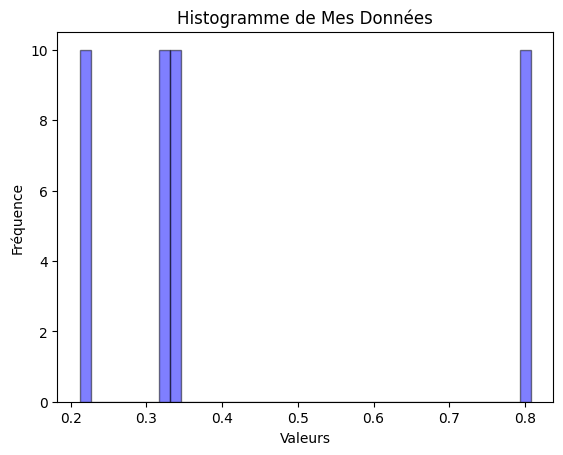

In [15]:
print(columns.shape)

print(min(columns[5]))
print(np.mean(columns[5]))
print(np.median(columns[5]))
# Créer l'histogramme
plt.hist(columns[5], bins=40, alpha=0.5, color='blue', edgecolor='black')

# Ajouter des titres et labels
plt.title('Histogramme de Mes Données')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')

# Afficher l'histogramme
plt.show()
